# Exercise 02

Brent Allen Thorne

## Objective
**Implement your own Gaussian Naïve Bayes:**
 - Try it on the toxicity data in the lecture
 - Check if you get the same results (probabilities and predictions)

See also: Appendix: Template from disscussion 02 slides.

## Reference Usage


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.naive_bayes import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay   

In [2]:
DATA_PATH = "./"
Train = pd.read_csv(f'{DATA_PATH}/molecular_train_gbc_cat.csv')
Test  = pd.read_csv(f'{DATA_PATH}/molecular_test_gbc_cat.csv')

In [3]:
Test.head()

,molecular_weight,electronegativity,bond_lengths,num_hydrogen_bonds,logP,label
0,341.704142,2.655846,3.094069,2,9.111473,Toxic
1,335.950798,3.222621,2.890393,7,8.928483,Toxic
2,235.203185,2.441153,2.482026,1,6.497307,Toxic
3,246.504930,2.766560,2.715472,7,7.450888,Toxic
4,437.938926,3.480105,3.595688,3,10.915629,Toxic


In [4]:
XTrain = Train.drop('label', axis = 1).values
YTrain = Train['label']
YTrain[:10]

0        Toxic
1        Toxic
2    Non-Toxic
3    Non-Toxic
4    Non-Toxic
5        Toxic
6    Non-Toxic
7    Non-Toxic
8        Toxic
9    Non-Toxic
Name: label, dtype: object

In [5]:
# scale training set... like a fish
scaler   = MinMaxScaler(feature_range = (0, 1)) 
XTrainS  = scaler.fit_transform(XTrain)

#extract X and Y from the test data set
XTest = Test.drop('label', axis = 1).values
YTest = Test['label']

#scaling the test set... like a snake
XTestS  = scaler.transform(XTest)

In [6]:
# Naive Bayes
gnb = GaussianNB()
Fit = gnb.fit(XTrainS, YTrain)

In [7]:
Ypred = Fit.predict(XTestS)        #predicting classes
Probs = Fit.predict_proba(XTestS)  #calculating probabilities for classes

In [8]:
Ypred[:30]

array(['Non-Toxic', 'Non-Toxic', 'Non-Toxic', 'Non-Toxic', 'Toxic',
       'Non-Toxic', 'Toxic', 'Toxic', 'Toxic', 'Non-Toxic', 'Toxic',
       'Toxic', 'Non-Toxic', 'Toxic', 'Non-Toxic', 'Toxic', 'Toxic',
       'Non-Toxic', 'Non-Toxic', 'Toxic', 'Toxic', 'Non-Toxic',
       'Non-Toxic', 'Non-Toxic', 'Non-Toxic', 'Toxic', 'Toxic',
       'Non-Toxic', 'Toxic', 'Non-Toxic'], dtype='<U9')

In [9]:
Probs[:10,:]

array([[5.19327002e-01, 4.80672998e-01],
       [8.95906620e-01, 1.04093380e-01],
       [9.99881760e-01, 1.18240334e-04],
       [9.99317916e-01, 6.82083528e-04],
       [2.99694345e-05, 9.99970031e-01],
       [7.79847793e-01, 2.20152207e-01],
       [4.08411098e-02, 9.59158890e-01],
       [4.25848802e-01, 5.74151198e-01],
       [2.70484008e-03, 9.97295160e-01],
       [9.88562550e-01, 1.14374499e-02]])

Using GaussianNB: 0.81


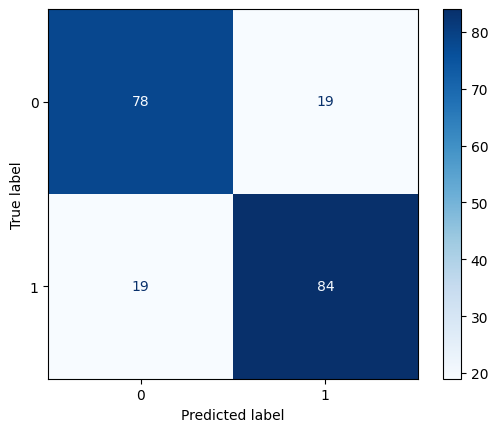

In [10]:
accuracy = np.mean(Ypred == YTest)
print(f'Using GaussianNB: {accuracy:.2f}')

cm = confusion_matrix(YTest, Ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [11]:
# help(GaussianNB)


Now that we have a baseline we can move on to our own implementation.


## Custom Naive Bayes Model (based on slides)

We've already curated our data so let's now focus on the model.

In [12]:
# Based on Example code from Discussion 02 Slides:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
# from sklearn.preprocessing import LabelEncoder # Let's not use this.

class MyGaussianNaiveBayes(BaseEstimator, ClassifierMixin):
    """
    a simple gaussian naive bayes classifier for binary classification.
    supports string or numeric labels using np.unique for internal mapping.
    """

    def fit(self, X, y):
        # grab our two unique labels and map them to 0 and 1
        self.classes_ = np.unique(y)
        if len(self.classes_) != 2:  # we can do better! pull yourself together kid.
            raise ValueError("this classifier only supports binary classification")

        # map labels to 0 and 1
        y_encoded = np.array([0 if label == self.classes_[0] else 1 for label in y])

        # collect rows by class
        X0 = X[y_encoded == 0]
        X1 = X[y_encoded == 1]

        if X0.shape[0] == 0 or X1.shape[0] == 0:
            raise ValueError("one of the classes is missing from training data")

        self.mean0 = np.mean(X0, axis=0)
        self.mean1 = np.mean(X1, axis=0)
        self.std0 = np.std(X0, axis=0)
        self.std1 = np.std(X1, axis=0)

        # avoid divide-by-zero
        self.std0[self.std0 == 0] = 1e-9
        self.std1[self.std1 == 0] = 1e-9

        # priors ought to be class proportions
        self.prior0 = np.mean(y_encoded == 0)
        self.prior1 = np.mean(y_encoded == 1)

        return self

    def _gaussian_pdf(self, X, mean, std):
        # write the gaussian distribution
        # use with caution as we don't handle edge cases
        exp = np.exp(-0.5 * ((X - mean) / std) ** 2)
        pdf = (1 / (std * np.sqrt(2 * np.pi))) * exp
        return pdf

    def predict_proba(self, X):
        # compute likelihoods for each class
        gaussian0 = self._gaussian_pdf(X, self.mean0, self.std0)
        gaussian1 = self._gaussian_pdf(X, self.mean1, self.std1)

        likelihood0 = np.prod(gaussian0, axis=1)  # consider underflow
        likelihood1 = np.prod(gaussian1, axis=1)

        posterior0 = likelihood0 * self.prior0
        posterior1 = likelihood1 * self.prior1

        total = posterior0 + posterior1
        # normalize and stack
        return np.vstack((posterior0 / total, posterior1 / total)).T

    def predict(self, X):
        proba = self.predict_proba(X)
        preds = np.argmax(proba, axis=1)
        # map back to original labels
        return np.array([self.classes_[i] for i in preds])

In [13]:
XTrainS[:10], YTrain[:10]

(array([[0.53349706, 0.06727023, 0.65368066, 0.33333333, 0.51312895],
        [0.59542698, 0.44676256, 0.58758461, 0.66666667, 0.51675971],
        [0.19740532, 0.35646807, 0.16862945, 0.88888889, 0.16758705],
        [0.3760369 , 0.41413257, 0.2789373 , 1.        , 0.38695547],
        [0.29836842, 0.40713483, 0.33184623, 0.11111111, 0.2867485 ],
        [0.58879989, 0.66644579, 0.56822708, 0.        , 0.58023607],
        [0.31740385, 0.33701428, 0.34534301, 0.22222222, 0.27108602],
        [0.32896871, 0.18850998, 0.27489319, 0.33333333, 0.23420979],
        [0.54612346, 0.4409044 , 0.52784515, 1.        , 0.51436297],
        [0.34649203, 0.62739627, 0.31129752, 0.55555556, 0.35430547]]),
 0        Toxic
 1        Toxic
 2    Non-Toxic
 3    Non-Toxic
 4    Non-Toxic
 5        Toxic
 6    Non-Toxic
 7    Non-Toxic
 8        Toxic
 9    Non-Toxic
 Name: label, dtype: object)

In [14]:
gnb = MyGaussianNaiveBayes()
Fit = gnb.fit(XTrainS, YTrain)

In [15]:
Ypred = Fit.predict(XTestS)        #predicting classes
Probs = Fit.predict_proba(XTestS)  #calculating probabilities for classes
Ypred[:10], Probs[:10]

(array(['Non-Toxic', 'Non-Toxic', 'Non-Toxic', 'Non-Toxic', 'Toxic',
        'Non-Toxic', 'Toxic', 'Toxic', 'Toxic', 'Non-Toxic'], dtype='<U9'),
 array([[5.19327002e-01, 4.80672998e-01],
        [8.95906621e-01, 1.04093379e-01],
        [9.99881760e-01, 1.18240327e-04],
        [9.99317917e-01, 6.82083493e-04],
        [2.99694313e-05, 9.99970031e-01],
        [7.79847795e-01, 2.20152205e-01],
        [4.08411086e-02, 9.59158891e-01],
        [4.25848801e-01, 5.74151199e-01],
        [2.70483993e-03, 9.97295160e-01],
        [9.88562550e-01, 1.14374495e-02]]))

In [16]:
YTest # we'll need to fix this for the score to work...

0          Toxic
1          Toxic
2          Toxic
3          Toxic
4          Toxic
         ...    
195    Non-Toxic
196        Toxic
197    Non-Toxic
198        Toxic
199        Toxic
Name: label, Length: 200, dtype: object

In [17]:
# hurray, it works now!
accuracy = gnb.score(XTestS, YTest)
accuracy

0.81

Using MyGaussianNaiveBayes from slides: 0.81


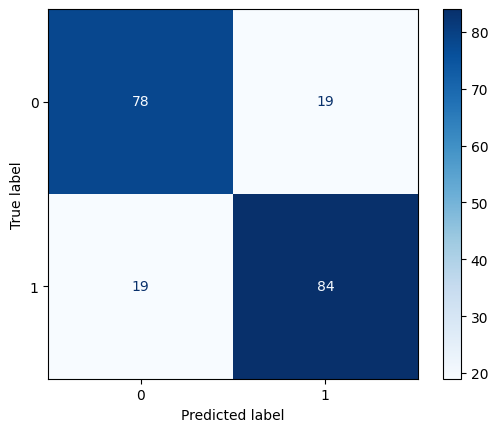

In [18]:
accuracy = np.mean(Ypred == YTest)
print(f'Using MyGaussianNaiveBayes from slides: {accuracy:.2f}')

cm = confusion_matrix(YTest, Ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Enhanced Naive Bayes Model (based on _BaseNB and SK-Learn docs)

Okay that worked fine however let's try to make this a bit more general now.
We want to support multiple classes rather than the binary starter code.
Also we want to consider numeric stablity to honor the old gods, as well as Clan, Golub and LeVeque.

See also:

https://sklearn-template.readthedocs.io/en/latest/user_guide.html

https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/naive_bayes.py  <-- particualy _BaseNB

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

In [19]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

class MyGaussianNB(BaseEstimator, ClassifierMixin):
    """
    A simple Gaussian Naive Bayes classifier that mimics sklearn.naive_bayes.GaussianNB.
    Uses log-space math for numerical stability and supports multiple classes.
    """

    def fit(self, X, y):
        """
        Fit the model using training data X and labels y.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Training feature matrix.
        y : ndarray of shape (n_samples,)
            Target labels.

        Returns
        -------
        self : object
            Fitted estimator.
        """
        self.classes_ = np.unique(y)  # aren't we clever? we grab all the classes at once
        self.mean_ = {}               # stash the mean for each class
        self.var_ = {}                # stash the variance too
        self.class_prior_ = {}        # and don't forget the priors

        # let's handle all the classes!
        for cls in self.classes_:
            X_cls = X[y == cls]  # filter rows where label == cls
            self.mean_[cls] = np.mean(X_cls, axis=0)  # compute mean per feature
            self.var_[cls] = np.var(X_cls, axis=0)    # compute variance per feature

            # avoid divide-by-zero!!! we don't want nan explosions
            self.var_[cls][self.var_[cls] == 0] = 1e-9

            # prior is just the fraction of samples in this class
            self.class_prior_[cls] = X_cls.shape[0] / X.shape[0]

        return self  # act right! we are learning scikit-learn conventions and we need this for pipelines

    def _log_gaussian_pdf(self, X, mean, var):
        """
        Compute the log of the Gaussian probability density function.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Input data.
        mean : ndarray of shape (n_features,)
            Mean vector for the class.
        var : ndarray of shape (n_features,)
            Variance vector for the class.

        Returns
        -------
        log_pdf : ndarray of shape (n_samples,)
            Log-likelihoods for each sample.
        """
        # use log gaussian pdf to match behaviour of sklearn.naive_bayes.GaussianNB()
        # use log-space math for stability!
        # also using np.prod over many features can underflow, so let's not do that.
        return -0.5 * np.sum(np.log(2 * np.pi * var) + ((X - mean) ** 2) / var, axis=1)

    def predict_proba(self, X):
        """
        Estimate class probabilities for each sample in X.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Input data.

        Returns
        -------
        probs : ndarray of shape (n_samples, n_classes)
            Probability estimates for each class.
        """
        log_posteriors = []  # we collect log posteriors for each class

        for cls in self.classes_:
            log_likelihood = self._log_gaussian_pdf(X, self.mean_[cls], self.var_[cls])  # how well X fits this class
            log_prior = np.log(self.class_prior_[cls])  # prior belief for this class
            log_posteriors.append(log_likelihood + log_prior)  # total log posterior

        log_posteriors = np.vstack(log_posteriors).T  # shape (n_samples, n_classes)

        # subtract max for numerical stability (this is the softmax trick)
        log_posteriors -= log_posteriors.max(axis=1, keepdims=True)

        probs = np.exp(log_posteriors)  # back to probability space
        probs /= probs.sum(axis=1, keepdims=True)  # normalize to sum to 1

        return probs

    def predict(self, X):
        """
        Predict class labels for samples in X.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Input data.

        Returns
        -------
        y_pred : ndarray of shape (n_samples,)
            Predicted class labels.
        """
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]  # pick the class with highest probability

In [20]:
# Docstrings help make it look like we might actually know what we're doing.
# This encourages us to not just write garabe code.
# Also we want to make Dr. Nash proud .;-)
# ...Chem274A seems so long ago.
help(MyGaussianNB)

Help on class MyGaussianNB in module __main__:

class MyGaussianNB(sklearn.base.BaseEstimator, sklearn.base.ClassifierMixin)
 |  A simple Gaussian Naive Bayes classifier that mimics sklearn.naive_bayes.GaussianNB.
 |  Uses log-space math for numerical stability and supports multiple classes.
 |
 |  Method resolution order:
 |      MyGaussianNB
 |      sklearn.base.BaseEstimator
 |      sklearn.utils._repr_html.base.ReprHTMLMixin
 |      sklearn.utils._repr_html.base._HTMLDocumentationLinkMixin
 |      sklearn.utils._metadata_requests._MetadataRequester
 |      sklearn.base.ClassifierMixin
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  fit(self, X, y)
 |      Fit the model using training data X and labels y.
 |
 |      Parameters
 |      ----------
 |      X : ndarray of shape (n_samples, n_features)
 |          Training feature matrix.
 |      y : ndarray of shape (n_samples,)
 |          Target labels.
 |
 |      Returns
 |      -------
 |      self : object
 |          F

In [21]:
# Fit using our Naive Bayes

gnb = MyGaussianNB()
Fit = gnb.fit(XTrainS, YTrain)

XTrainS

array([[0.53349706, 0.06727023, 0.65368066, 0.33333333, 0.51312895],
       [0.59542698, 0.44676256, 0.58758461, 0.66666667, 0.51675971],
       [0.19740532, 0.35646807, 0.16862945, 0.88888889, 0.16758705],
       ...,
       [0.39173844, 0.49860329, 0.30416491, 0.66666667, 0.30633569],
       [0.41845845, 0.2915314 , 0.34347286, 0.66666667, 0.39760027],
       [0.49766515, 0.65004831, 0.43733788, 0.33333333, 0.50186866]],
      shape=(800, 5))

In [22]:
Ypred = Fit.predict(XTestS)        #predicting classes
Probs = Fit.predict_proba(XTestS)  #calculating probabilities for classes

In [23]:
Probs[:10]

array([[5.19327002e-01, 4.80672998e-01],
       [8.95906621e-01, 1.04093379e-01],
       [9.99881760e-01, 1.18240327e-04],
       [9.99317917e-01, 6.82083493e-04],
       [2.99694313e-05, 9.99970031e-01],
       [7.79847795e-01, 2.20152205e-01],
       [4.08411086e-02, 9.59158891e-01],
       [4.25848801e-01, 5.74151199e-01],
       [2.70483993e-03, 9.97295160e-01],
       [9.88562550e-01, 1.14374495e-02]])

Using MyGaussianNB: 0.81


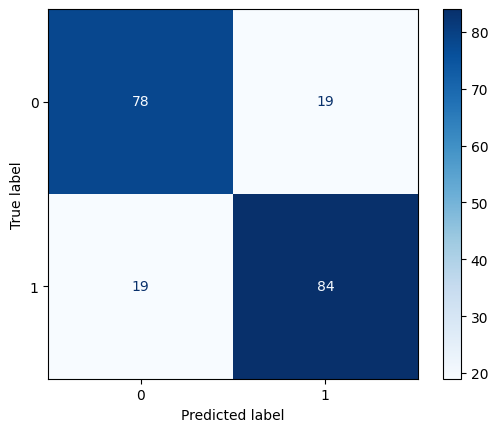

In [24]:
accuracy = np.mean(Ypred == YTest)
print(f'Using MyGaussianNB: {accuracy:.2f}')

cm = confusion_matrix(YTest, Ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

How about that?!  Herr Gauss is right again.

In [25]:
# we get all the normal behaviour for free now
accuracy = gnb.score(XTestS, YTest)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.810


## Conclusion

We started by adapting the starter code to encode labels and implement the `_gaussian_pdf()` function. Then we fixed up `fit()` to return `self`, and inherited from `BaseEstimator` and `ClassifierMixin` so we play nice with pipelines.

To align the behavior of our classifier with that of `sklearn.naive_bayes.GaussianNB()`, we analyzed the `_BaseNB` and `GaussianNB()` sources.
We tried to strike a balance between correctness, clarity and readablity, while applying scientific programming techniques to improve numerical stability and accuracy.

We utilized log-space math for numeric stability, computing the log of the Gaussian probability density function, prior and posteriors.
To avoid numerical overflow, we applied the softmax trick by subtracting the row-wise maximum before exponentiating log-probabilities.

# Appendix

## Template from disscussion 02 slides.

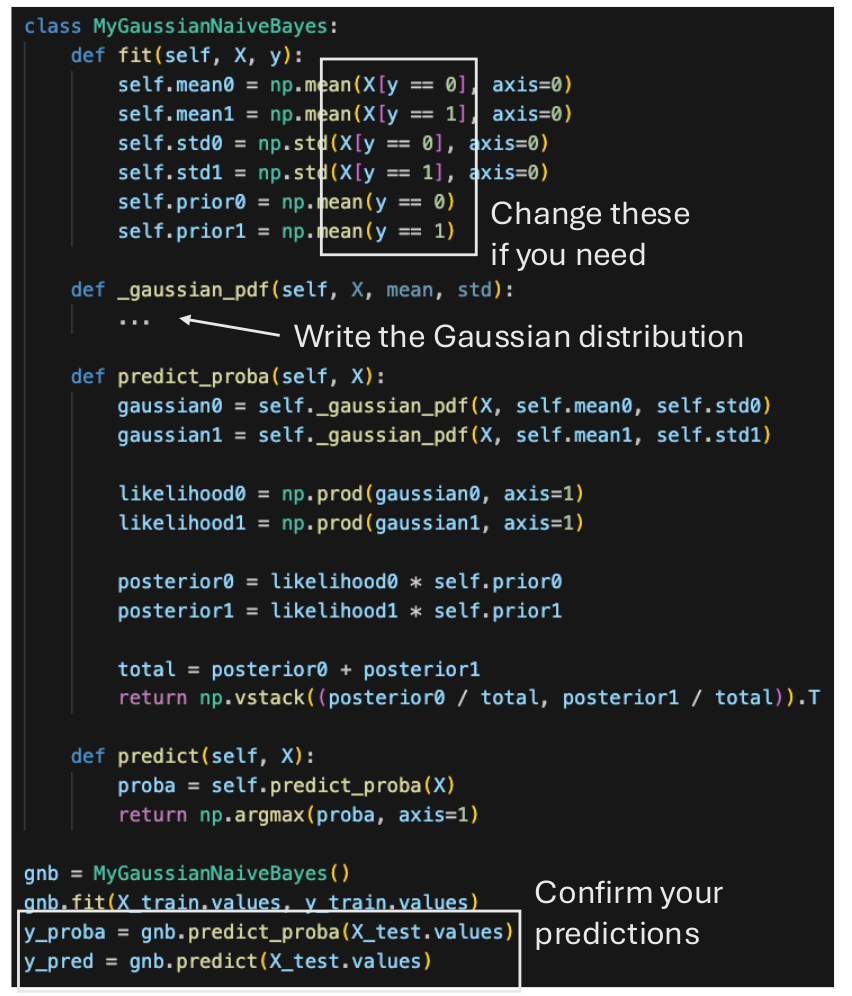

## Addition Resources

https://sklearn-template.readthedocs.io/en/latest/user_guide.html

https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/naive_bayes.py  <-- particualy _BaseNB

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html

## Future Directions

Think about time complexity in training and testing modes.

Consider how to profile and compare performance of our models.

Consider how we might do online updates to model parameters.

 - See: Stanford CS tech report STAN-CS-79-773 by Chan, Golub, and LeVeque (http://i.stanford.edu/pub/cstr/reports/cs/tr/79/773/CS-TR-79-773.pdf)
